<a href="https://colab.research.google.com/github/bingjeff/colony/blob/main/image_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
img.data

IPython.core.display.Image

In [80]:
#@title Google TF labeling tools.
# Lint as: python3
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Utils for colab tutorials located in object_detection/colab_tutorials/..."""
import base64
import io
import json
from typing import Dict
from typing import List
from typing import Union
import uuid

from IPython.display import display
from IPython.display import Image as IPythonImage
from IPython.display import Javascript
import numpy as np
from PIL import Image

from google.colab import output
from google.colab.output import eval_js

from tensorflow.io import gfile
import numpy as np


def image_from_numpy(image):
  """Open an image at the specified path and encode it in Base64.

  Args:
    image: np.ndarray
      Image represented as a numpy array

  Returns:
    An encoded Base64 representation of the image
  """

  with io.BytesIO() as img_output:
    Image.fromarray(image).save(img_output, format='JPEG')
    data = img_output.getvalue()
  data = str(base64.b64encode(data))[2:-1]
  return data

def image_from_path(image_path):
  """Open an image at the specified path and encode it in Base64.

  Args:
    image: np.ndarray
      Image represented as a numpy array

  Returns:
    An encoded Base64 representation of the image
  """
  img = IPythonImage(image_path)
  data = str(base64.b64encode(img.data))[2:-1]
  return data


def draw_bbox(image_urls, callbackId):  # pylint: disable=invalid-name
  """Open the bounding box UI and send the results to a callback function.

  Args:
    image_urls: list[str | np.ndarray]
      List of locations from where to load the images from. If a np.ndarray is
      given, the array is interpretted as an image and sent to the frontend.
      If a str is given, the string is interpreted as a path and is read as a
      np.ndarray before being sent to the frontend.

    callbackId: str
      The ID for the callback function to send the bounding box results to
      when the user hits submit.
  """
  js = Javascript('''
              async function load_image(imgs, callbackId) {
                  //init organizational elements
                  const div = document.createElement('div');
                  var image_cont = document.createElement('div');
                  var errorlog = document.createElement('div');
                  var crosshair_h = document.createElement('div');
                  crosshair_h.style.position = "absolute";
                  crosshair_h.style.backgroundColor = "transparent";
                  crosshair_h.style.width = "100%";
                  crosshair_h.style.height = "0px";
                  crosshair_h.style.zIndex = 9998;
                  crosshair_h.style.borderStyle = "dotted";
                  crosshair_h.style.borderWidth = "2px";
                  crosshair_h.style.borderColor = "rgba(255, 0, 0, 0.75)";
                  crosshair_h.style.cursor = "crosshair";
                  var crosshair_v = document.createElement('div');
                  crosshair_v.style.position = "absolute";
                  crosshair_v.style.backgroundColor = "transparent";
                  crosshair_v.style.width = "0px";
                  crosshair_v.style.height = "100%";
                  crosshair_v.style.zIndex = 9999;
                  crosshair_v.style.top = "0px";
                  crosshair_v.style.borderStyle = "dotted";
                  crosshair_v.style.borderWidth = "2px";
                  crosshair_v.style.borderColor = "rgba(255, 0, 0, 0.75)";
                  crosshair_v.style.cursor = "crosshair";
                  crosshair_v.style.marginTop = "23px";
                  var brdiv = document.createElement('br');


                  //init control elements
                  var next = document.createElement('button');
                  var prev = document.createElement('button');
                  var submit = document.createElement('button');
                  var deleteButton = document.createElement('button');
                  var deleteAllbutton = document.createElement('button');

                  //init image containers
                  var image = new Image();
                  var canvas_img = document.createElement('canvas');
                  var ctx = canvas_img.getContext("2d");
                  canvas_img.style.cursor = "crosshair";
                  canvas_img.setAttribute('draggable', false);
                  crosshair_v.setAttribute('draggable', false);
                  crosshair_h.setAttribute('draggable', false);

                  // bounding box containers
                  const height = 600
                  var allBoundingBoxes = [];
                  var curr_image = 0
                  var im_height = 0;
                  var im_width = 0;

                  //initialize bounding boxes
                  for (var i = 0; i < imgs.length; i++) {
                    allBoundingBoxes[i] = [];
                  }
                  //initialize image view
                  errorlog.id = 'errorlog';
                  image.style.display = 'block';
                  image.setAttribute('draggable', false);

                  //load the first image
                  function drawImage() {
                    // normalize display height and canvas
                    const scale = height / image.naturalHeight;
                    image.height = height;
                    image.width = scale * image.naturalWidth;
                    image_cont.height = canvas_img.height = image.height;
                    image_cont.width = canvas_img.width = image.width;
                    crosshair_v.style.height = image_cont.height + "px";
                    crosshair_h.style.width = image_cont.width + "px";

                    // draw the new image
                    ctx.drawImage(image, 0, 0, image.naturalWidth, image.naturalHeight, 0, 0,  canvas_img.width,  canvas_img.height);
                  }
                  img = imgs[curr_image];
                  image.src = "data:image/png;base64," + img;
                  image.onload = drawImage;

                  // move to next image in array
                  next.textContent = "next image";
                  next.onclick = function(){
                      if (curr_image < imgs.length - 1){
                          // clear canvas and load new image
                          curr_image += 1;
                          errorlog.innerHTML = "";
                      }
                      else{
                          errorlog.innerHTML = "All images completed!!";
                      }
                      resetcanvas();
                  }

                  //move forward through list of images
                  prev.textContent = "prev image"
                  prev.onclick = function(){
                      if (curr_image > 0){
                          // clear canvas and load new image
                          curr_image -= 1;
                          errorlog.innerHTML = "";
                      }
                      else{
                          errorlog.innerHTML = "at the beginning";
                      }
                      resetcanvas();
                  }
                  // on delete, deletes the last bounding box
                  deleteButton.textContent = "undo bbox";
                  deleteButton.onclick = function(){
                    boundingBoxes.pop();
                    ctx.clearRect(0, 0, canvas_img.width, canvas_img.height);
                    image.src = "data:image/png;base64," + img;
                    image.onload = function() {
                        ctx.drawImage(image, 0, 0, image.naturalWidth, image.naturalHeight, 0, 0,  canvas_img.width,  canvas_img.height);
                        boundingBoxes.map(r => {drawRect(r)});
                    };
                  }
                  // on all delete, deletes all of the bounding box
                  deleteAllbutton.textContent = "delete all"
                  deleteAllbutton.onclick = function(){
                    boundingBoxes = [];
                    ctx.clearRect(0, 0, canvas_img.width, canvas_img.height);
                    image.src = "data:image/png;base64," + img;
                    image.onload = function() {
                        ctx.drawImage(image, 0, 0, image.naturalWidth, image.naturalHeight, 0, 0,  canvas_img.width,  canvas_img.height);
                        //boundingBoxes.map(r => {drawRect(r)});
                    };
                  }

                  // on submit, send the boxes to display
                  submit.textContent = "submit";
                  submit.onclick = function(){
                    errorlog.innerHTML = "";

                    // send box data to callback fucntion
                    google.colab.kernel.invokeFunction(callbackId, [allBoundingBoxes], {});
                  }

                // init template for annotations
                const annotation = {
                      x: 0,
                      y: 0,
                      w: 0,
                      h: 0,
                };

                // the array of all rectangles
                let boundingBoxes = allBoundingBoxes[curr_image];

                // the actual rectangle, the one that is being drawn
                let o = {};

                // a variable to store the mouse position
                let m = {},

                // a variable to store the point where you begin to draw the
                // rectangle
                start = {};

                // a boolean variable to store the drawing state
                let isDrawing = false;
                var elem = null;

                function handleMouseDown(e) {
                  // on mouse click set change the cursor and start tracking the mouse position
                  start = oMousePos(canvas_img, e);

                  // configure is drawing to true
                  isDrawing = true;
                }

                function handleMouseMove(e) {
                    // move crosshairs, but only within the bounds of the canvas
                    if (document.elementsFromPoint(e.pageX, e.pageY).includes(canvas_img)) {
                      crosshair_h.style.top = e.pageY + "px";
                      crosshair_v.style.left = e.pageX + "px";
                    }

                    // move the bounding box
                    if(isDrawing){
                      m = oMousePos(canvas_img, e);
                      draw();
                    }
                }

                function handleMouseUp(e) {
                    if (isDrawing) {
                        // on mouse release, push a bounding box to array and draw all boxes
                        isDrawing = false;

                        const box = Object.create(annotation);

                        // calculate the position of the rectangle
                        if (o.w > 0){
                          box.x = o.x;
                        }
                        else{
                          box.x = o.x + o.w;
                        }
                        if (o.h > 0){
                          box.y = o.y;
                        }
                        else{
                          box.y = o.y + o.h;
                        }
                        box.w = Math.abs(o.w);
                        box.h = Math.abs(o.h);

                        // Add the bounding box to the image if it is real sized.
                        if (box.w < image.naturalWidth && box.h < image.naturalHeight) {
                          boundingBoxes.push(box);
                        }

                        draw();
                    }
                }

                function draw() {
                    o.x = (start.x)/image.width;  // start position of x
                    o.y = (start.y)/image.height;  // start position of y
                    o.w = (m.x - start.x)/image.width;  // width
                    o.h = (m.y - start.y)/image.height;  // height

                    ctx.clearRect(0, 0, canvas_img.width, canvas_img.height);
                    ctx.drawImage(image, 0, 0, image.naturalWidth, image.naturalHeight, 0, 0,  canvas_img.width,  canvas_img.height);
                    // draw all the rectangles saved in the rectsRy
                    boundingBoxes.map(r => {drawRect(r)});
                    // draw the actual rectangle
                    drawRect(o);
                }

                // add the handlers needed for dragging
                crosshair_h.addEventListener("mousedown", handleMouseDown);
                crosshair_v.addEventListener("mousedown", handleMouseDown);
                document.addEventListener("mousemove", handleMouseMove);
                document.addEventListener("mouseup", handleMouseUp);


                function resetcanvas(){
                    // clear canvas
                    ctx.clearRect(0, 0, canvas_img.width, canvas_img.height);
                    img = imgs[curr_image]
                    image.src = "data:image/png;base64," + img;

                    // onload init new canvas and display image
                    image.onload = function() {
                        // draw the new image
                        drawImage();

                        // draw bounding boxes
                        boundingBoxes = allBoundingBoxes[curr_image];
                        boundingBoxes.map(r => {drawRect(r)});
                    };
                }

                function drawRect(o){
                    // draw a predefined rectangle
                    ctx.strokeStyle = "red";
                    ctx.lineWidth = 2;
                    ctx.beginPath(o);
                    ctx.rect(o.x * image.width, o.y * image.height, o.w * image.width, o.h * image.height);
                    ctx.stroke();
                }

                // Function to detect the mouse position
                function oMousePos(canvas_img, evt) {
                  let ClientRect = canvas_img.getBoundingClientRect();
                    return {
                      x: evt.clientX - ClientRect.left,
                      y: evt.clientY - ClientRect.top
                    };
                }


                //configure colab output display
                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                //build the html document that will be seen in output
                div.appendChild(document.createElement('br'))
                div.appendChild(image_cont)
                image_cont.appendChild(canvas_img)
                image_cont.appendChild(crosshair_h)
                image_cont.appendChild(crosshair_v)
                div.appendChild(document.createElement('br'))
                div.appendChild(errorlog)
                div.appendChild(prev)
                div.appendChild(next)
                div.appendChild(deleteButton)
                div.appendChild(deleteAllbutton)
                div.appendChild(document.createElement('br'))
                div.appendChild(brdiv)
                div.appendChild(submit)
                document.querySelector("#output-area").appendChild(div);
                return
            }''')

  # load the images as a byte array
  bytearrays = []
  for image in image_urls:
    if isinstance(image, np.ndarray):
      bytearrays.append(image_from_numpy(image))
    elif isinstance(image, str):
      bytearrays.append(image_from_path(image))
    else:
      raise TypeError('Image has unsupported type {}.'.format(type(image)))

  # format arrays for input
  image_data = json.dumps(bytearrays)
  del bytearrays

  # call java script function pass string byte array(image_data) as input
  display(js)
  eval_js('load_image({}, \'{}\')'.format(image_data, callbackId))
  return


def annotate(imgs: List[Union[str, np.ndarray]],  # pylint: disable=invalid-name
             box_storage_pointer: List[np.ndarray],
             callbackId: str = None):
  """Open the bounding box UI and prompt the user for input.

  Args:
    imgs: list[str | np.ndarray]
      List of locations from where to load the images from. If a np.ndarray is
      given, the array is interpretted as an image and sent to the frontend. If
      a str is given, the string is interpreted as a path and is read as a
      np.ndarray before being sent to the frontend.

    box_storage_pointer: list[np.ndarray]
      Destination list for bounding box arrays. Each array in this list
      corresponds to one of the images given in imgs. The array is a
      N x 4 array where N is the number of bounding boxes given by the user
      for that particular image. If there are no bounding boxes for an image,
      None is used instead of an empty array.

    callbackId: str, optional
      The ID for the callback function that communicates between the fontend
      and the backend. If no ID is given, a random UUID string is used instead.
  """

  # Set a random ID for the callback function
  if callbackId is None:
    callbackId = str(uuid.uuid1()).replace('-', '')

  def dictToList(input_bbox):  # pylint: disable=invalid-name
    """Convert bbox.

    This function converts the dictionary from the frontend (if the format
    {x, y, w, h} as shown in callbackFunction) into a list
    ([y_min, x_min, y_max, x_max])

    Args:
      input_bbox:

    Returns:
      A list with bbox coordinates in the form [ymin, xmin, ymax, xmax].
    """
    return (input_bbox['y'], input_bbox['x'], input_bbox['y'] + input_bbox['h'],
            input_bbox['x'] + input_bbox['w'])

  def callbackFunction(annotations: List[List[Dict[str, float]]]):  # pylint: disable=invalid-name
    """Callback function.

    This is the call back function to capture the data from the frontend and
    convert the data into a numpy array.

    Args:
      annotations: list[list[dict[str, float]]]
        The input of the call back function is a list of list of objects
        corresponding to the annotations. The format of annotations is shown
        below

        [
          // stuff for image 1
          [
            // stuff for rect 1
            {x, y, w, h},
            // stuff for rect 2
            {x, y, w, h},
            ...
          ],
          // stuff for image 2
          [
            // stuff for rect 1
            {x, y, w, h},
            // stuff for rect 2
            {x, y, w, h},
            ...
          ],
          ...
        ]
    """

    # reset the boxes list
    nonlocal box_storage_pointer
    boxes: List[np.ndarray] = box_storage_pointer
    boxes.clear()

    # load the new annotations into the boxes list
    for annotations_per_img in annotations:
      rectangles_as_arrays = [np.clip(dictToList(annotation), 0, 1)
                              for annotation in annotations_per_img]
      if rectangles_as_arrays:
        boxes.append(np.stack(rectangles_as_arrays))
      else:
        boxes.append(None)

    # output the annotations to the errorlog
    with output.redirect_to_element('#errorlog'):
      display('--boxes array populated--')

  output.register_callback(callbackId, callbackFunction)
  draw_bbox(imgs, callbackId)

def load_image_into_numpy_array(path):
  img_data = gfile.GFile(path, 'rb').read()
  image = Image.open(io.BytesIO(img_data))
  (im_width, im_height) = image.size
  image_np = np.array(image.getdata(), dtype=np.uint8)
  return image_np.reshape((im_height, im_width, 3))

In [17]:
#@title LabelingTool class.
# Modified from: https://github.com/dida-do/public/tree/master/labelingtool
import pathlib
import ipywidgets

from IPython import display

# from IPython.display import Image, clear_output, display
# from ipywidgets import Button, HBox, Output, Layout


class LabelingTool:
    """A tool to be used for image classification labeling.
    Needs to run in a jupyter notebook to display ipywidgets.
    Attributes:
        classes: A list of image classes to be assigned during labeling.
        path: The path to the directory that contains the images.
        images: A list of the image files in the directory.
        current: Pointer to the current position of the tool.
        labels: Dictionary with assigned labels {'filename': 'label'}.
    """

    def __init__(
        self,
        classes: list,
        path: str = None,
        images: list = None,
    ) -> None:
        """Construct all necessary attributes for the LabelingTool object.
        Args:
            classes: List of candidate labels (typically strings).
            path: Path to the directory containing the images to be labeled.
        """
        # store list of available class labels
        self.classes = classes

        # store path and list of images in path
        if images:
          self.images = images
        elif path:
          image_path = pathlib.Path(path)
          self.images = [image_path / f.name for f in image_path.glob("*.jpg")]

        # set up empty dict for labels and initial position
        self.labels = {}
        self.position = 0

    def _next(self, *args) -> None:
        """Select the next image and updates the displays.
        Args:
            *args: Variable length argument list, allows to pass Button object.
        """
        # update position
        self.position += 1
        if self.position == len(self.images):
            self.position = 0

        # refresh display
        image = display.Image(self.images[self.position])
        with self.frame:
            display.clear_output(wait=True)
            display.display(image)

    def _go_back(self, *args) -> None:
        """Select the previous image and updates the displays.
        Do not do anything if it is the first image.
        Args:
            *args: Variable length argument list, allows to pass Button object.
        """
        # update position
        self.position -= 1
        if self.position == -1:
            self.position = len(self.images) - 1

        # refresh display
        image = display.Image(self.images[self.position])
        with self.frame:
            display.clear_output(wait=True)
            display.display(image)

    def _select_label(self, button: ipywidgets.Button) -> None:
        """Attach a label to the current image and stores it.
        Link the label from a given button to the current image and store it
        in the labels dictionary and in the current working directory as .json.
        Args:
            button (ipywidgets.Button): a button supplying the label to be
                associated with the current image
        """
        # store label
        current_image = self.images[self.position]
        self.labels[current_image] = button.description

        # move on
        self._next()

    def start(self) -> None:
        """Start the labeling procedure.
        Load the first image to label and set up the user interface.
        """
        # image frame
        image = display.Image(self.images[self.position])
        self.frame = ipywidgets.Output(layout=ipywidgets.Layout(height="300px", max_width="300px"))
        with self.frame:
            display.display(image)

        # navigation buttons
        backward_button = ipywidgets.Button(description="< go back")
        backward_button.on_click(self._go_back)
        forward_button = ipywidgets.Button(description="next >")
        forward_button.on_click(self._next)
        self.navigation_buttons = [backward_button, forward_button]

        # class label buttons
        self.class_buttons = []
        for label in self.classes:
            label_button = ipywidgets.Button(description=label)
            label_button.on_click(self._select_label)
            self.class_buttons.append(label_button)

        # display contents
        display.display(self.frame)
        display.display(ipywidgets.HBox(self.navigation_buttons))
        display.display(ipywidgets.HBox(self.class_buttons))

In [26]:
LABELS = ['eye', 'mouth', 'nose', 'cheek']
DATA_DIR = 'https://github.com/hhoppe/data/raw/main/'
IMAGE = DATA_DIR + 'image.png'

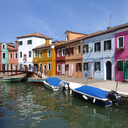

In [10]:
img = display.Image(IMAGE)
display.display(img)

In [63]:
import numpy as np
from matplotlib import pyplot as plt

img = plt.imread(IMAGE)
im = np.asarray(img)
im2 = np.array(255 * im, dtype=np.uint8)

<ipython-input-63-499b6d0170ec>:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = plt.imread(IMAGE)


In [56]:
type(im)

numpy.ndarray

In [82]:
boxes = []
annotate([im2], box_storage_pointer=boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [78]:
boxes

[array([[0.07440104, 0.06833333, 0.07606771, 0.06833333],
        [0.20606771, 0.17333333, 0.62773437, 0.58166667]])]